In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'image.interpolation': 'nearest', 'savefig.dpi': 100,
})

import numpy as np
from pathlib import Path
import os

FIG_DIR = Path('figures')
os.makedirs(FIG_DIR, exist_ok=True)
rng = np.random.default_rng()

# Hexagonal arena

Position inside arena will be discretized according to a hexagonal grid.

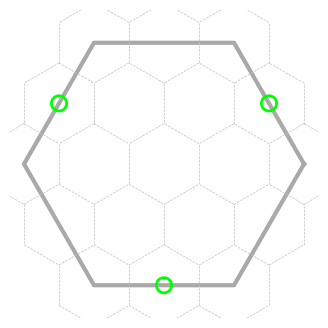

In [2]:
from hexarena.arena import Arena

arena = Arena(2)
fig, ax = plt.subplots(figsize=(4, 4))
arena.plot_mesh(ax)
fig.savefig(FIG_DIR/'arena-map.svg')

# Foodbox

An example of volatile box is shown, with the box quality switching randomly.

Poisson food box with tau=15 (kappa=0.1) run for 120 steps with random push


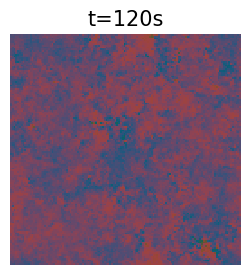

In [3]:
from hexarena.box import PoissonBox
from hexarena.color import get_cmap

cmap = get_cmap()
box = PoissonBox(tau=15., kappa=0.1)

box.reset()

fig, ax = plt.subplots(figsize=(3, 3))
h = ax.imshow(box.colors, vmin=0, vmax=1, cmap=cmap)
h_title = ax.set_title('', fontsize='medium')
ax.set_axis_off()

def init():
    box.reset()
    h.set_data(box.colors)
    return h, h_title

def update(t):
    box.step(rng.random()<0.05)
    h.set_data(box.colors)
    h_title.set_text(f't={t}s')
    return h, h_title

num_frames = 120
print('{} run for {} steps with random push'.format(box, num_frames))
ani = FuncAnimation(fig, update, frames=range(num_frames+1), init_func=init, blit=True)

ani.save(FIG_DIR/'poisson.box.gif')

# Foraging environment

Here shows an environment similar to the actual experiment, where three food boxes are set up. Quality of each box is fixed during the experiment, and we use high noise for cue due to the lack of monitor information in the preliminary data.

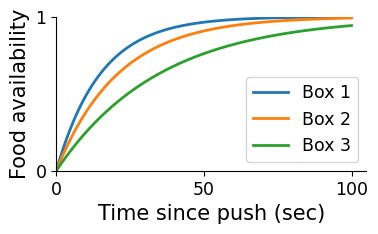

In [4]:
time = np.linspace(0, 100, 100)

fig, ax = plt.subplots(figsize=(4, 2))
for tau in [15, 21, 35]:
    p = 1-np.exp(-time/tau)
    ax.plot(time, p)
ax.set_xlim([0, None])
ax.set_xticks([0, 50, 100])
ax.set_xlabel('Time since push (sec)')
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
ax.set_ylabel('Food availability')
plt.legend(['Box 1', 'Box 2', 'Box 3'], fontsize='small')

fig.savefig(FIG_DIR/'monkey-boxes-cue.svg')

## Run an example trial with random policy

In [5]:
from hexarena.env import SimilarBoxForagingEnv

env = SimilarBoxForagingEnv(
    box={
        '_target_': 'hexarena.box.StationaryBox',
        'num_levels': 10, 'kappa': 0.1,
    },
    boxes=[
        {'tau': 5}, {'tau': 20}, {'tau': 80},
    ],
)
env.boxes

[Box with tau: (5), Box with tau: (20), Box with tau: (80)]

In [6]:
num_steps = 600

_, info = env.reset()
pos, gaze, rewarded = [info['pos']], [info['gaze']], [None]
foods, colors = [info['foods']], [info['colors']]
counts = [np.zeros((3, 2), dtype=int)] # successful and total counts for each box
for _ in range(num_steps):
    action = env.action_space.sample()
    push, move, _ = env.monkey.convert_action(action)
    observation, *_, info = env.step(action)
    
    pos.append(info['pos'])
    gaze.append(info['gaze'])
    foods.append(info['foods'])
    colors.append(info['colors'])
    _counts = counts[-1].copy()
    if push:
        rewarded.append(bool(observation[-1]))
        b_idx = env.arena.boxes.index(move)
        _counts[b_idx, 0] += observation[-1]
        _counts[b_idx, 1] += 1
    else:
        rewarded.append(None)
    counts.append(_counts)
pos, gaze = np.array(pos), np.array(gaze)
foods, colors = np.array(foods), np.array(colors)
counts = np.array(counts)

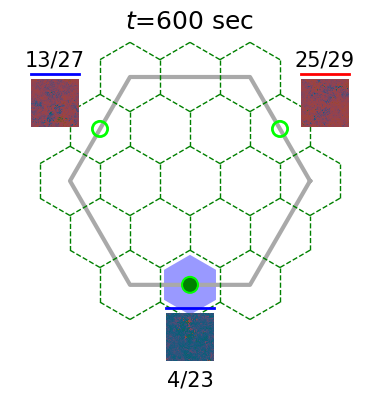

In [7]:
fig, ani = env.play_episode(pos, gaze, rewarded, foods, colors, counts)
ani.save(FIG_DIR/'example-trial.gif', fps=12)